## Importing Libraries

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## Generating Data 

Here we are trying to generate the dataset for the poisson regression problem. This code is written to generate a dataset with 3 independent variables/covariates. If one wish to add more variables simply add more X_i s following particular distribution according to the probelm. To generate the respons variables first we generated the covariates and genereated mean of the responses by simply following the canonical link for poisson distributed data. Finally, the response variables were generated by drawing samples from a distribution with calculated mean.

In [30]:

def generate_poisson_data(n=10, beta0=1, betas=[0.2, 0.3, -0.1]):
    
    #Generates data for a Poisson regression model with three specific predictors:
    #X1 - Uniformly distributed,
    #X2 - Normally distributed (mean=0, std=1),
    #X3 - Normally distributed (mean=2, std=1).
    
    #Input:
    #    n (int): Number of samples.
    #    beta0 (float): Intercept coefficient.
    #    betas (list of float): Coefficients for the predictor variables, [beta1, beta2, beta3].
    
    #Output:
    #   X (ndarray): 2D array of predictor values.
    #   y (ndarray): Array of response values from the Poisson distribution.
    
    # Generate covariate values
    X1 = np.random.uniform(low=0, high=1.5, size=n)   # X1 - Uniform distribution
    X2 = np.random.uniform(low=-1, high=1, size=n)   # X2 - Uniform distribution
    X3 = np.random.uniform(low=1, high=3, size=n)   # X3 - Uniform distribution
    X = np.column_stack((X1, X2, X3))                 # Stack arrays column-wise

    # Compute linear predictor as beta0 + sum(betas * X, axis=1)
    linear_predictor = beta0 + np.dot(X, np.array(betas))
    
    # Compute mu's using the exponential link function
    mu = np.exp(linear_predictor)
    
    # Generate Y-values from a Poisson distribution
    y = np.random.poisson(lam=mu)
    
    return X, y

## Function for Poisson Regression

In [38]:

class PoissonRegression(nn.Module):
    def __init__(self, input_dim, use_bias=True):
        super(PoissonRegression, self).__init__()
        # In Poisson regression, we typically include the bias to handle the intercept
        self.linear = nn.Linear(input_dim, 1, bias=use_bias)
    
    def forward(self, x):
        # Applying the linear layer and exponentiating the output
        # to ensure the rate parameter λ is positive
        return torch.exp(self.linear(x))

def train_poisson_regression(X_data, Y_data, epochs=200, learning_rate=0.1, use_bias=False):
    input_dim = X_data.shape[1]
    
    # Converting X, y into tensors
    X_data = torch.tensor(X_data, dtype=torch.float32)
    Y_data = torch.tensor(Y_data, dtype=torch.float32).view(-1, 1)
    
    # Creating the instance of Poisson regression
    model = PoissonRegression(input_dim, use_bias)
    
    # Poisson loss (negative log likelihood)
    criterion = torch.nn.PoissonNLLLoss(log_input=False)  # Set `log_input=False` because our model already outputs exp(linear(x))
    
    # Using a stochastic gradient descent optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    all_losses = []
    
    for epoch in range(epochs):
        # Forward pass
        outputs = model(X_data)
        loss = criterion(outputs, Y_data)
        all_losses.append(loss.item())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    plt.plot(all_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model, all_losses


In [42]:
def calculate_mse_r2(model,y_true, y_pred,use_bias=False):


    #model parameter
    print('Estimated Model Paramter:',model.linear.weight.data.numpy())
    if use_bias:
        print('Estimated Bias:',model.linear.bias.item())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate Mean Squared Error
    mse = np.linalg.norm(y_true - y_pred)
    norm = np. linalg.norm(y_true-np.mean(y_true))**2
    
    nmse = mse/norm


    # Calculate R-squared (Coefficient of Determination)
    ss_res = np.sum((y_true - y_pred) ** 2)  # Sum of squares of residuals
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)  # Total sum of squares
    r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 1.0  # Check to prevent division by zero, also R² can't exceed 1

    return nmse, r2

##  Experiment 1 

### Data Generation

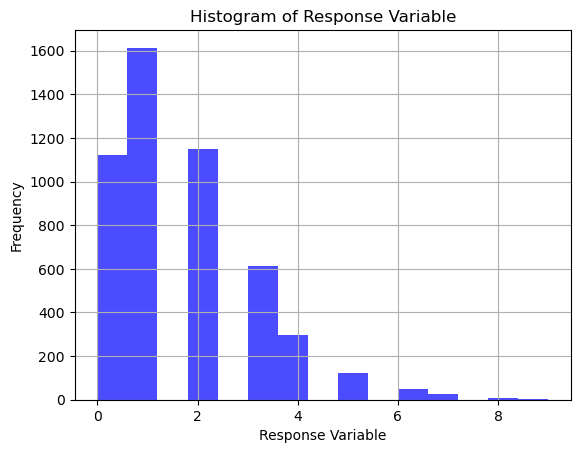

In [43]:

samples = 5000
bias = 0
betas = [0.8,0.2,-0.1 ]
X,y = generate_poisson_data(samples, bias, betas)

# Plotting the histogram of 'y'
plt.hist(y, bins=15, color='blue', alpha=0.7)  # You can adjust the number of bins and color as needed
plt.xlabel('Response Variable')
plt.ylabel('Frequency')
plt.title('Histogram of Response Variable')
plt.grid(True)
plt.show()

n_train = 4000
n_test = 1000

X_train = X[0:(n_train),:]
y_train = y[0:(n_train)]
X_test = X[(n_train):(n_train+n_test),:]
y_test = y[(n_train):(n_train+n_test)]


### Poisson Regression

Epoch [10/600], Loss: 2.1366
Epoch [20/600], Loss: 1.5223
Epoch [30/600], Loss: 1.1694
Epoch [40/600], Loss: 1.0150
Epoch [50/600], Loss: 0.9580
Epoch [60/600], Loss: 0.9339
Epoch [70/600], Loss: 0.9189
Epoch [80/600], Loss: 0.9064
Epoch [90/600], Loss: 0.8952
Epoch [100/600], Loss: 0.8849
Epoch [110/600], Loss: 0.8754
Epoch [120/600], Loss: 0.8665
Epoch [130/600], Loss: 0.8583
Epoch [140/600], Loss: 0.8507
Epoch [150/600], Loss: 0.8437
Epoch [160/600], Loss: 0.8372
Epoch [170/600], Loss: 0.8311
Epoch [180/600], Loss: 0.8255
Epoch [190/600], Loss: 0.8203
Epoch [200/600], Loss: 0.8154
Epoch [210/600], Loss: 0.8109
Epoch [220/600], Loss: 0.8067
Epoch [230/600], Loss: 0.8029
Epoch [240/600], Loss: 0.7993
Epoch [250/600], Loss: 0.7959
Epoch [260/600], Loss: 0.7928
Epoch [270/600], Loss: 0.7899
Epoch [280/600], Loss: 0.7872
Epoch [290/600], Loss: 0.7847
Epoch [300/600], Loss: 0.7824
Epoch [310/600], Loss: 0.7802
Epoch [320/600], Loss: 0.7782
Epoch [330/600], Loss: 0.7763
Epoch [340/600], Lo

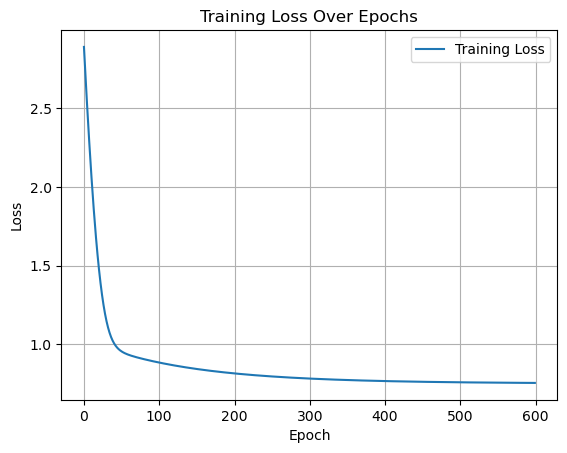

Estimated Model Paramter: [[ 0.6166669   0.13928205 -0.01482609]]
Normalized Mean Squared Error: 0.010339031750830781
R-squared: 0.14361944244793134
Normalised Estimation Error for parameter estimation: 0.05363464927154465


In [47]:
#Training 
learning_rate = 0.01
use_bias = False
epochs = 600
Regressor,Losses = train_poisson_regression(X_train, y_train, epochs, learning_rate, use_bias)

#predtiction

y_predicted = Regressor(torch.tensor(X_train, dtype=torch.float32)).detach().numpy()


#training error 

mse, r2 = calculate_mse_r2(Regressor,y_train.reshape(-1,1),y_predicted,use_bias)
print(f"Normalized Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

#estimation error

# Calculate the squared norm of the difference between true and estimated parameters
error_norm = np.linalg.norm(betas - Regressor.linear.weight.data.numpy() ) ** 2
    
# Calculate the norm of the true parameters
true_norm = np.linalg.norm(betas)

#normalized estimation error 
nee = error_norm/true_norm
print('Normalised Estimation Error for parameter estimation:',nee)